# **Connectivity and Modularity: Trends and Thematic Dynamics in the Music Network on Top-100 selling albums from 1960 to 2023**

**Author: Sitong Chen (s230027)**

## **Introduction**

The evolution of the music industry is shaped by a dynamic interplay of cultural, technological, and artistic forces. While traditional music analysis often emphasizes metrics such as sales figures or the emotional tone of individual works, it frequently overlooks the intricate relationships between albums and their broader impact on the industry's evolution.

This study seeks to bridge that gap by introducing a novel framework for understanding these connections. By modeling the top 100 best-selling albums from each year between 1960 and 2023 as a complex network, we aim to explore how musical styles, themes, and influences are interconnected over time.

## **Data Collection**

The dataset for this study was constructed from multiple reliable sources to ensure comprehensiveness and accuracy. The top 100 best-selling albums from each year between 1960 and 2023 were collected from the [Digital Dream Door website](https://digitaldreamdoor.com/). Album track names were retrieved using the [MusicBrainz API](https://musicbrainz.org/), while song lyrics were downloaded via the [Genius API](https://genius.com/).

After preprocessing and aggregation, including the removal of albums lacking genre information, the final dataset contains **37,483 rows** and **17 variables**, encompassing diverse aspects of the albums and their tracks.

### **Download Ablums**

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import os

# Loop through the years from 1960 to 2023
for year in range(1960, 2024):
    # URL to scrape
    url = f"https://digitaldreamdoor.com/pages/albums_by_year/albums_{year}.html"

    # Simulate browser headers for the HTTP request
    headers = {
        "User-Agent": (
            "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
            "AppleWebKit/537.36 (KHTML, like Gecko) "
            "Chrome/89.0.4389.82 Safari/537.36"
        )
    }

    # Send a GET request to the URL
    response = requests.get(url, headers=headers)

    # Check if the request was successful
    if response.status_code == 200:
        # Parse the webpage content with BeautifulSoup
        soup = BeautifulSoup(response.content, "html.parser")

        # List to store album and artist data
        albums_and_artists = []

        # First structure parsing logic
        divs = soup.find_all("div", class_="list")
        for div in divs:
            album_rows = div.text.split('\n')  # Split rows by newline
            for row in album_rows:
                if " - " in row:  # Identify rows with album and artist data
                    parts = row.split(" - ", 1)  # Split into album and artist
                    album = parts[0].split(".", 1)[-1].strip()  # Extract album name
                    artist = parts[1].strip()  # Extract artist name
                    albums_and_artists.append({"Album Name": album, "Artist Name": artist})

        # If data was extracted using the first structure
        if albums_and_artists:
            df = pd.DataFrame(albums_and_artists)
            df['Year'] = year

        # Second structure parsing logic (fallback if the first method fails)
        if not albums_and_artists:
            for div in divs:
                lines = div.stripped_strings  # Extract clean lines from the div
                for line in lines:
                    if " - " in line:  # Identify lines with album and artist data
                        parts = line.split(" - ", 1)  # Split into album and artist
                        album = parts[0].split(".", 1)[-1].strip()  # Extract album name
                        artist = parts[1].strip()  # Extract artist name
                        albums_and_artists.append({"Album Name": album, "Artist Name": artist})
            
            # If data was extracted using the second structure
            if albums_and_artists:
                df = pd.DataFrame(albums_and_artists)
                df['Year'] = year

        # Create a directory to save CSV files if it does not exist
        if not os.path.exists("album"):
            os.makedirs("album")

        # Save the data to a CSV file
        df.to_csv(f"album/top100_albums_{year}.csv", index=False, encoding="utf-8")
    else:
        # Print an error message if the request fails
        print(f"Failed request, status code: {response.status_code}")


### **Download the Songs in Each Ablum**

In [ ]:
import musicbrainzngs
import pandas as pd
import time

# Initialize MusicBrainz API with a user agent
musicbrainzngs.set_useragent("AlbumInfoFetcher", "1.0", "your_email@example.com")

# Function to fetch album songs and metadata
def get_album_songs(album_name):
    try:
        # Search for the album using the MusicBrainz API
        result = musicbrainzngs.search_releases(release=album_name, limit=1)
        
        # Check if any results are found
        if not result['release-list']:
            print(f"No results found for album: {album_name}")
            return []

        # Select the first matching album
        release = result['release-list'][0]
        release_id = release['id']

        # Fetch detailed album information using the release ID
        album_data = musicbrainzngs.get_release_by_id(release_id, includes=["recordings", "tags"])
        release_info = album_data['release']
        tracks = release_info['medium-list'][0]['track-list']

        # Extract general album metadata
        album_details = {
            "Album Name": album_name,
            "Status": release_info.get('status', 'Unknown'),
            "Quality": release_info.get('quality', 'Unknown'),
            "Packaging": release_info.get('packaging', 'Unknown'),
            "Language": release_info.get('text-representation', {}).get('language', 'Unknown'),
            "Script": release_info.get('text-representation', {}).get('script', 'Unknown'),
            "Release Date": release_info.get('date', 'Unknown'),
            "Release Country": release_info.get('country', 'Unknown'),
            "Has Artwork": release_info.get('cover-art-archive', {}).get('artwork', 'false'),
            "Front Cover Available": release_info.get('cover-art-archive', {}).get('front', 'false'),
            "Back Cover Available": release_info.get('cover-art-archive', {}).get('back', 'false'),
        }

        # Extract track-level metadata
        songs = []
        for track in tracks:
            recording = track.get('recording', {})
            
            # Extract tags/genres for the recording
            recording_tags = recording.get('tag-list', [])
            recording_genres = ", ".join([tag['name'] for tag in recording_tags]) if recording_tags else "Unknown"

            # Combine album-level and track-level metadata
            song_details = {
                "Track Number": track.get('position', 'Unknown'),
                "Title": recording.get('title', 'Unknown'),
                "Length (ms)": recording.get('length', 'Unknown'),
                "Recording Genres": recording_genres if recording_genres else "Unknown",
                **album_details,
            }
            songs.append(song_details)

        return songs

    except Exception as e:
        # Handle exceptions and print error messages
        print(f"Error fetching album data: {e}")
        return []


In [ ]:
import os
if not os.path.exists("songs"):
    os.makedirs("songs")
for year in range(1960,2024):
    df = pd.read_csv(f'album/top100_albums_{year}.csv')
    all_songs = []
    for name in df['Album Name']:
        songs_data = get_album_songs(name)
        if songs_data:
            all_songs.extend(songs_data)
    
    if all_songs:
        df_all_songs = pd.DataFrame(all_songs)
        df_all_songs.to_csv(f"songs/top100_albums_{year}_songs.csv", index=False)
        print(f'finish exacting{year}')

## **Network Construction and Analysis for Albums**

### **Network Construction**
Each **album** is represented as a node in the network. The **genre set** of an album is determined by collecting and deduplicating the genre sets of all its constituent songs. 

To establish edges between albums, the **Jaccard Similarity** between the genre sets of two albums is used. The Jaccard Similarity is defined as:

$$
\text{Jaccard Similarity} = \frac{|A \cap B|}{|A \cup B|}$$

where $A$ and $B$ are the genre sets of two albums.

Edges between albums are created based on varying similarity thresholds: **0.2, 0.3, 0.4, 0.5, 0.6**.


### **Network Structure Analysis**
The following structural features of the resulting networks are analyzed:

1. **Number of nodes and edges**: 
   The total number of albums (nodes) and connections (edges) in the network.
2. **Power-law distribution**: 
   Analysis of whether the degree distribution follows a power-law pattern.
3. **Average degree**:
   The average number of edges per node in the network.
4. **Number of connected components**: 
   The count of isolated and connected groups of nodes within the network.

In order to figure out the best threshold to build the network.

In [1]:
import pandas as pd

# collect and clean all genres for each album
albums_genres = {}
albums_year = {}

for year in range(1960, 2024):
    df = pd.read_csv(f'02805_project_data/songs_lyrics/top100_albums_{year}_songs.csv')
    df['Recording Genres'] = df['Recording Genres'].apply(lambda x: x.split(', ')) # Convert string to list
    df['Recording Genres'] = df['Recording Genres'].apply(lambda x: [genre for genre in x if genre!= 'Unknown'] if isinstance(x, list) else x)# Remove 'Unknown' genre
    df = df[df['Recording Genres'].apply(lambda x: x != [])]# Remove empty lists

    
    for album_name in df['Album Name'].unique():
        genres = df[df['Album Name'] == album_name]['Recording Genres']# Get all genres for the album
        genres = [genre for sublist in genres for genre in sublist]
        albums_genres[album_name] = set(genres)# Remove duplicates and convert to dictionary 
        year = df[df['Album Name'] == album_name]['Year'].values[0]
        albums_year[album_name] = int(year)

In [2]:
import networkx as nx
import powerlaw
import pandas as pd
import warnings

def jaccard_similarity(set1, set2):
    return len(set1 & set2) / len(set1 | set2)

# Thresholds to analyze
thresholds = [0.2, 0.3, 0.4, 0.5, 0.6]

results = []

for threshold in thresholds:
    G = nx.Graph()
    for album in albums_genres.keys():  # Add nodes
        G.add_node(album)  

    album_list = list(albums_genres.keys())
    for i in range(len(album_list)):
        for j in range(i + 1, len(album_list)):
            album1, album2 = album_list[i], album_list[j]
            similarity = jaccard_similarity(albums_genres[album1], albums_genres[album2])  # Calculate Jaccard similarity
            if similarity > threshold:
                G.add_edge(album1, album2, weight=similarity)
    
    G_undirected = G.to_undirected()  # Convert to undirected graph
    degrees = [d for n, d in G_undirected.degree() if d > 0]  # Exclude zero degrees
    
    if degrees:  # Fit only if there are valid degrees
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            fit = powerlaw.Fit(degrees)  # Fit the degree distribution to a power law
        alpha = fit.alpha
    else:
        alpha = None
    
    results.append({
        "Threshold": threshold,
        "Alpha (power law)": alpha,
        "Number of nodes": G_undirected.number_of_nodes(),
        "Number of edges": G_undirected.number_of_edges(),
        "Average degree": sum(degrees) / len(degrees) if degrees else None,
        "Number of connected components": nx.number_connected_components(G_undirected)
    })


# Convert results to a DataFrame
df_results = pd.DataFrame(results)
df_results


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


,Threshold,Alpha (power law),Number of nodes,Number of edges,Average degree,Number of connected components
0,0.2,9.231406,3849,506472,266.634377,55
1,0.3,2.608504,3849,155558,84.062686,161
2,0.4,2.211909,3849,44930,27.379647,620
3,0.5,2.440319,3849,11497,9.685762,1664
4,0.6,2.286321,3849,4951,6.138872,2450


1. **Threshold = 0.2 and 0.3: Overly Dense**
   - **Edges**: 506,472 (0.2), 155,558 (0.3)
   - **Average degree**: 266.63 (0.2), 84.06 (0.3)
   - **Power-law exponent**: 9.23 (0.2)
   - These high-density networks exhibit excessive connectivity between nodes, obscuring the sparsity required to reveal meaningful structural features, such as community detection. The deviation of power-law exponent  from the common range further indicates an uncharacteristic network structure.

2. **Threshold = 0.5 and 0.6: Overly Sparse**
   - **Edges**: 11,497 (0.5), 4,951 (0.6)
   - **Average degree**: 9.69 (0.5), 6.14 (0.6)
   - **Connected components**: 1,664 (0.5), 2,450 (0.6)
   - While the power-law exponents fall within a reasonable range, the networks' connectivity decreases significantly, with many isolated nodes or small groups. This lack of global connectivity hinders the analysis of key network properties, such as centrality or path length distribution.

3. **Threshold = 0.4: Balanced**
   - **Edges**: 44,930
   - **Average degree**: 27.38
   - **Connected components**: 620
   - **Power-law exponent**: 2.21
   - This network retains global connectivity while capturing sparsity characteristics, making it well-suited for analyzing both local and global features. The connected components remain manageable, ensuring that the network remains analyzable as a whole.

#### **Conclusion: Threshold = 0.4**
The network at **threshold = 0.4** achieves the best balance, suitable for analyzing both local and global properties. We proceed with this threshold for network construction.


In [ ]:
import networkx as nx
def jaccard_similarity(set1, set2):
    return len(set1 & set2) / len(set1 | set2)
# based on the statistics information, we choose the threshold as 0.4 and build the network
G = nx.Graph()
for album in albums_genres.keys():  #add nodes
    G.add_node(album)  

# add edges
threshold = 0.4  # threshold
album_list = list(albums_genres.keys())
for i in range(len(album_list)):
    for j in range(i + 1, len(album_list)):
        album1, album2 = album_list[i], album_list[j]
        similarity = jaccard_similarity(albums_genres[album1], albums_genres[album2])
        if similarity > threshold:
            G.add_edge(album1, album2, weight=similarity)

for album in albums_genres.keys():
    G.add_node(album, year=albums_year[album], genres=albums_genres[album])

G_undirected = G.to_undirected()  # Convert to undirected graph

---

## **Connectivity and Modularity: Trends and Thematic Dynamics in the Music Network**

### **Centrality Analysis: Revealing the Overall Connectivity and Trends of the Music Network**

We conducted a centrality analysis of the network, including examining its **betweenness centrality**, **eigenvector centrality**, and **degree centrality**.

In [ ]:
# save the network to a pickle file the network includes two kinds of attributes ‘year and genres’
import pickle
with open('G_undirected.pkl', 'wb') as f:
    pickle.dump(G_undirected, f)

In [1]:
import pickle
with open('G_undirected.pkl', 'rb') as f:
    G_undirected = pickle.load(f)

In [ ]:
import networkx as nx
import pandas as pd
import ast
degree_centrality = nx.degree_centrality(G_undirected)
betweenness_centrality = nx.betweenness_centrality(G_undirected)
eigenvector_centrality = nx.eigenvector_centrality(G_undirected)

year_dict = nx.get_node_attributes(G_undirected, 'year')
genres_dict = nx.get_node_attributes(G_undirected, 'genres')

# Build DataFrame
centrality_data = {
    "Album": list(degree_centrality.keys()),
    "Degree Centrality": list(degree_centrality.values()),
    "Betweenness Centrality": list(betweenness_centrality.values()),
    "Eigenvector Centrality": list(eigenvector_centrality.values()),
    "Genres": [
        list(ast.literal_eval(genres_dict[node])) if isinstance(genres_dict[node], str) else list(genres_dict[node])
        for node in degree_centrality.keys()
    ],
    "Year": [year_dict[node] for node in degree_centrality.keys()]
}

centrality_df = pd.DataFrame(centrality_data)

# divide the year into decades
centrality_df['Decade'] = (centrality_df['Year'] // 10) * 10
centrality_df.to_csv('centrality.csv', index=False)

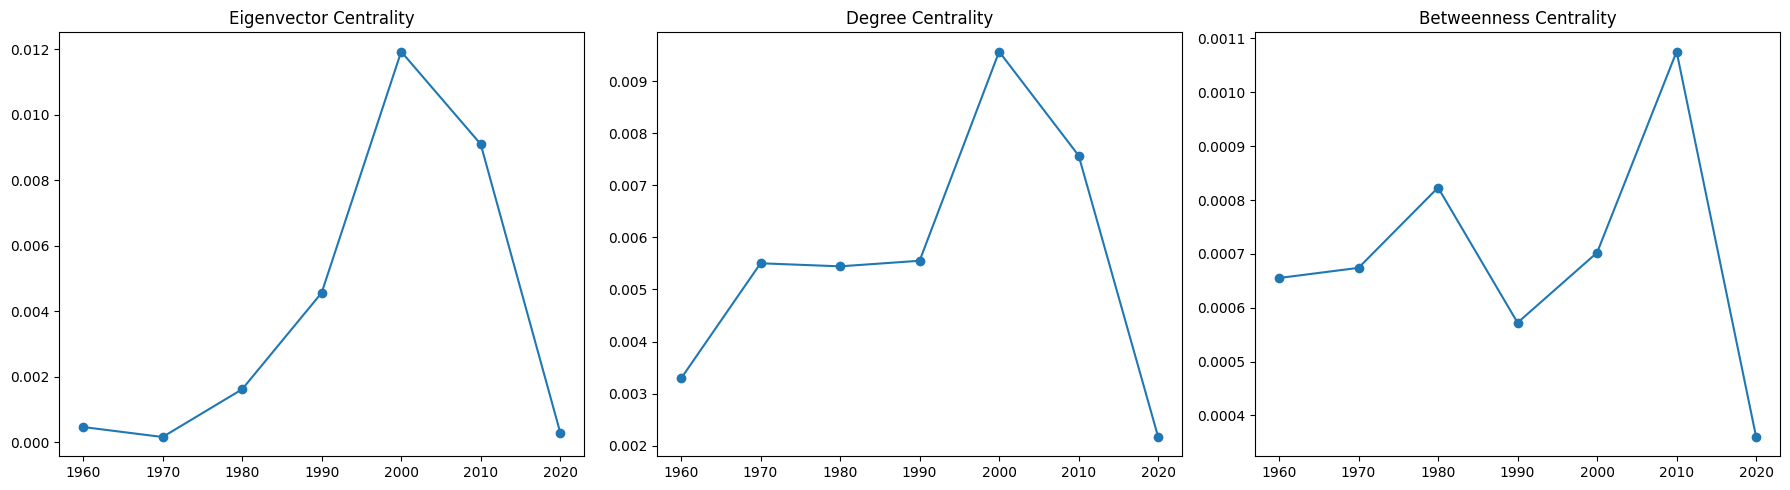

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
# read the centrality data
centrality_df = pd.read_csv('centrality.csv')
# calculate the betweenness centrality,degree centrality and eigenvector centrality
grouped_EC_df = centrality_df.groupby('Decade')['Eigenvector Centrality'].mean().reset_index()
grouped_DC_df = centrality_df.groupby('Decade')['Degree Centrality'].mean().reset_index()
grouped_BC_df = centrality_df.groupby('Decade')['Betweenness Centrality'].mean().reset_index()
dataframes = [grouped_EC_df, grouped_DC_df, grouped_BC_df]
titles = ['Eigenvector Centrality', 'Degree Centrality', 'Betweenness Centrality']
y_columns = ['Eigenvector Centrality', 'Degree Centrality', 'Betweenness Centrality']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loop through dataframes and plot
for i, (df, title, y_col) in enumerate(zip(dataframes, titles, y_columns)):
    axes[i].plot(df['Decade'], df[y_col], marker='o')
    axes[i].set_title(title)

plt.tight_layout()
plt.show()


#### **Phenomenon 1: Peak in Eigenvector and Degree Centrality in the 2000s**
- **High Eigenvector Centrality**:  
  Indicates that albums from the 2000s had more connections with other influential and central albums in the network. This suggests that the themes of albums during this period were highly aligned with both previous and contemporary popular themes, deeply integrating into the "core" of the network.  

- **High Degree Centrality**:  
  Reflects that albums from this period had the highest number of direct connections, being associated with more albums overall. This likely points to the universal nature of music themes around the 2000s, with a significant degree of overlap or similarity across many albums.

> **Summary**: The 2000s can be seen as the "core years" of the music network, characterized by dense and centralized connections. This indicates a relatively unified or widespread adoption of musical themes during this era, linking albums from various decades.
---

#### **Phenomenon 2: Peak in Betweenness Centrality in the 2010s**
- **High Betweenness Centrality**:  
  Albums from the 2010s played a critical role in connecting different eras and genre clusters within the music network. These albums bridged the popular themes of the 2000s with the increasingly dispersed themes of later periods.

> **Summary**: The 2010s may represent a transitional phase in musical themes, shifting from the concentrated trends of the 2000s to the more diversified and fragmented styles emerging afterward. Albums from this period both extended previous popular themes and explored new styles, making them key connectors between the old and the new.


---
#### **Phenomenon 3: Decline of All Centrality Metrics Post-2010s**
While we cannot draw definitive conclusions here due to incomplete data for the 2020s (as it is still 2024), we can hypothesize:  
- Post-2010s, the genre distribution of albums may become more fragmented, with fewer transitional albums serving as bridges.  
- Music styles might become increasingly niche and diverse, leading to lower overall connectivity in the network.



#### **Conclusion**
From the trends in network centrality metrics, we can infer the following:  
- **Albums from the 2000s were the center of the music network, demonstrating the strongest connectivity and influence.**  
- **Albums from the 2010s served as transitional nodes, linking concentrated older themes with more fragmented newer ones.**  
- **Post-2010s, albums appear to lose connectivity and centrality, indicating a shift toward more diverse and decentralized music themes.**  
----

### **Community Detection: Exploring Modular Changes in Musical Themes within the Network**

Centrality metrics reveal the connectivity characteristics and overall trends of albums from different years: centralization in the 2000s, transitional nature in the 2010s, and decentralization after the 2010s. However, do these trends specifically reflect changes in themes or groups? Are there clear community (genre group) dynamics? To verify this, we employed community detection methods to analyze the modular structure of the music network, further exploring the accuracy of these observations.

In [4]:
import community as community_louvain
import networkx as nx
isolated_nodes = list(nx.isolates(G_undirected))

# remove isolated nodes
G_undirected.remove_nodes_from(isolated_nodes)
louvain_partition = community_louvain.best_partition(G_undirected)

for node in isolated_nodes:
    louvain_partition[node] = -1
    
# calculate the modularity
louvain_modularity = community_louvain.modularity(louvain_partition, G_undirected)
print(f"Louvain score: {louvain_modularity}")

Louvain score: 0.6604271015209282


In the first step of community detection, we used the **Louvain algorithm** to divide the undirected network into communities and calculated the **modularity**, which scored **0.66**. This indicates a significant modular structure within the network. Nodes in the music network tend to cluster within the same community, forming relatively cohesive genre or stylistic groups, while connections between communities are sparser. This modularity provides a solid foundation for further analysis of how musical themes manifest within communities and how these communities evolve over time.

We applied the **Louvain algorithm** to divide the network into multiple communities and used the **ForceAtlas2 layout** to visualize the top 10 largest communities.

/var/folders/rt/lb9jfwsn0d59wvs6_f0ptpjm0000gn/T/ipykernel_51081/1070719773.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab20", len(top_communities))  # Use the tab20 color palette
100%|██████████| 2000/2000 [02:23<00:00, 13.90it/s]


BarnesHut Approximation  took  36.33  seconds
Repulsion forces  took  99.30  seconds
Gravitational forces  took  0.48  seconds
Attraction forces  took  1.68  seconds
AdjustSpeedAndApplyForces step  took  2.74  seconds


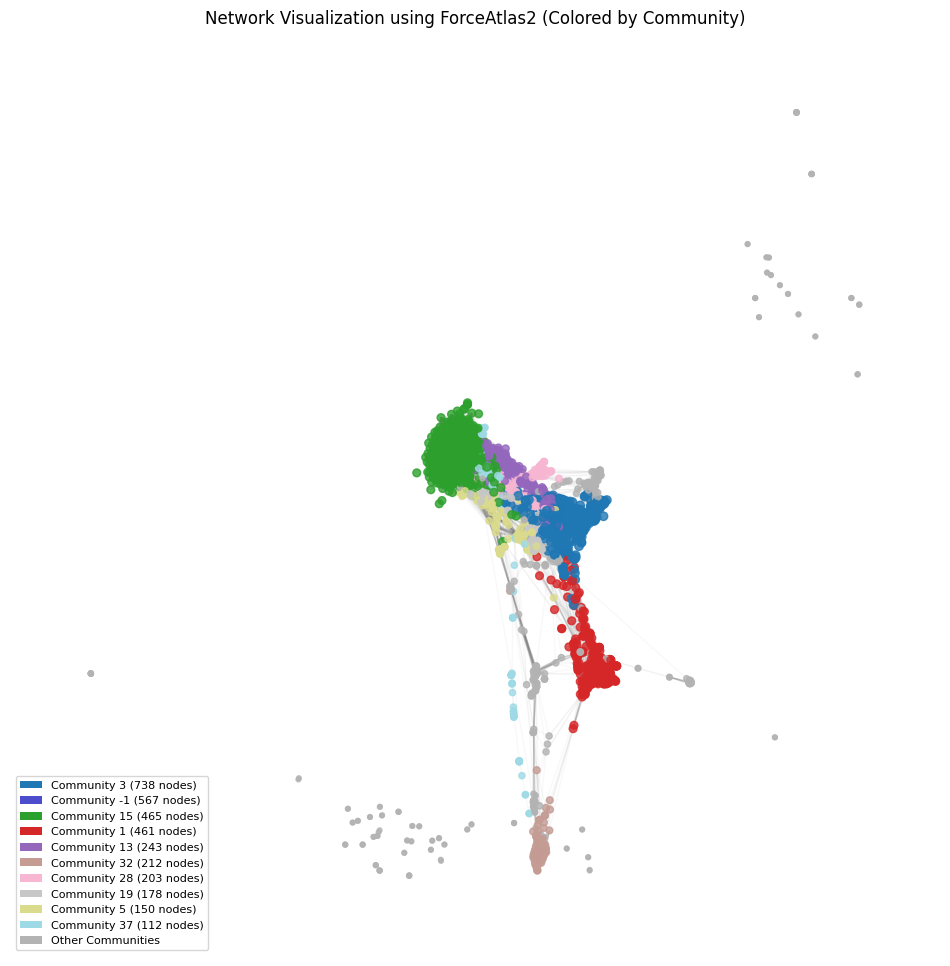

In [5]:
import networkx as nx
import matplotlib.pyplot as plt
from fa2_modified import ForceAtlas2
from matplotlib.patches import Patch
from matplotlib import cm

# Assign different colors to the top 10 largest communities, and use gray for smaller communities
community_sizes = {}
for node, community in louvain_partition.items():
    if community not in community_sizes:
        community_sizes[community] = 0
    community_sizes[community] += 1

# Sort communities by size
sorted_communities = sorted(community_sizes, key=community_sizes.get, reverse=True)
top_communities = sorted_communities[:10]  # Select the top 10 largest communities

# Generate colors using a color map
cmap = cm.get_cmap("tab20", len(top_communities))  # Use the tab20 color palette

color_map = {}
for i, community in enumerate(top_communities):
    color_map[community] = cmap(i)[:3]  # Extract RGB
color_map[-1] = (0.3, 0.3, 0.8)  # Assign a deep blue color for isolated nodes

# Use gray for smaller communities and isolated nodes
for community in sorted_communities[10:]:
    color_map[community] = (0.7, 0.7, 0.7)  # Gray

node_colors = [color_map[louvain_partition[node]] for node in G_undirected.nodes()]

# Adjust node size based on community size (isolated nodes are larger)
node_sizes = [
    50 if louvain_partition[node] == -1 else 10 + community_sizes[louvain_partition[node]] ** 0.5
    for node in G_undirected.nodes()
]

# Step 3: Use the ForceAtlas2 algorithm to compute node layout
forceatlas2 = ForceAtlas2(
    outboundAttractionDistribution=True,  # Dissuade hubs
    linLogMode=False,  # Use linear distances
    adjustSizes=False,  # Prevent overlap
    edgeWeightInfluence=1.0,
    jitterTolerance=1.0,
    barnesHutOptimize=True,
    barnesHutTheta=1,
    scalingRatio=75,
    strongGravityMode=False,
    gravity=3,
    verbose=True
)

positions = forceatlas2.forceatlas2_networkx_layout(G_undirected, pos=None, iterations=2000)

# Draw the network graph
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(
    G_undirected, 
    pos=positions, 
    node_color=node_colors, 
    node_size=[
        80 if louvain_partition[node] == -1 else node_sizes[i]
        for i, node in enumerate(G_undirected.nodes())
    ], 
    alpha=0.8,
)
nx.draw_networkx_edges(
    G_undirected, 
    pos=positions, 
    edge_color="gray", 
    alpha=[
        0.2 if louvain_partition[edge[0]] == -1 or louvain_partition[edge[1]] == -1 else 0.05 
        for edge in G_undirected.edges()
    ]
)

plt.title("Network Visualization using ForceAtlas2 (Colored by Community)")
legend_elements = [
    Patch(facecolor=color_map[community], label=f"Community {community} ({community_sizes[community]} nodes)")
    for community in top_communities
]
legend_elements.append(Patch(facecolor=(0.7, 0.7, 0.7), label="Other Communities"))
plt.legend(handles=legend_elements, loc="lower left", fontsize=8)

plt.axis('off')  # Hide axes
plt.show()


- **Major Communities:** Community 3 (blue), Community 1 (red), and Community 15 (green) are the three largest communities, containing 738, 461, and 465 nodes respectively, forming the core of the network. They represent mainstream musical themes or styles.  
- **Isolated Nodes and Small Communities:** Blue nodes (Community -1) represent isolated nodes, which are weakly connected to the mainstream network, reflecting unique niche musical themes or independent artists.  
- **Inter-community Connectivity:** There are certain connections between different communities, especially among the core communities, indicating some level of genre or stylistic correlation and blending.  
- **Modular Structure:** The boundaries between communities are distinct, with dense connections within communities and sparse connections between them. This aligns with the modularity score (0.659), which highlights the modular characteristics of the network.  
- **Layout Characteristics:** The core communities are more densely distributed, while smaller communities and isolated nodes are dispersed around the periphery, reflecting the dominant influence of core themes on the overall network.

By further analyzing the characteristics of nodes within each community, we can deepen our understanding of the modular structure of the music network and assess the accuracy of observations regarding centralization in the 2000s, transition in the 2010s, and decentralization after the 2010s.


---

#### **Investigation 1: Were albums from the 2000s the center of the music network, demonstrating the strongest connectivity and influence?**


To validate the statement that "albums from the 2000s were the center of the music network, demonstrating the strongest connectivity and influence," we conducted a detailed analysis of the distribution of 2000s albums across different communities. Specifically, we calculated the following metrics:

1. **Proportion of each community in the 2000s:**  
   The proportion of a specific community's albums from the 2000s relative to the total number of albums in the 2000s.  
   $$
   \text{Proportion of a community in the 2000s} = \frac{\text{Number of albums from the 2000s in a community}}{\text{Total number of albums from the 2000s}}
   $$

2. **Overall proportion of each community:**  
   The proportion of a specific community's total number of albums relative to the total number of albums in the entire network.  
   $$
   \text{Overall proportion of a community} = \frac{\text{Total number of albums in a community}}{\text{Total number of albums in the network}}
   $$

3. **Temporal trends in album distribution across communities:**  
   The distribution trend of a specific community's albums over time, measured as the proportion of albums from each decade relative to the community's total albums.  
   $$
   \text{Temporal trend for a community in a decade} = \frac{\text{Number of albums from a decade in a community}}{\text{Total number of albums in that community}}
   $$


In [6]:
import pandas as pd
centrality_df= pd.read_csv('centrality.csv')
louvain_partition_df = pd.DataFrame(
    {"Album": list(louvain_partition.keys()), "Community": list(louvain_partition.values())}
)
centrality_df = centrality_df.merge(louvain_partition_df, on="Album", how="left")



In [7]:
top_10_communities = (centrality_df["Community"]
                      .value_counts()
                      .sort_values(ascending=False)
                      .head(10)
                      .index.tolist())
centrality_df_top10_orgian = centrality_df[centrality_df['Community'].isin(top_10_communities)]
centrality_df_top10= centrality_df_top10_orgian.groupby(['Decade','Community']).size().unstack(fill_value=0)
centrality_df_top10['Total'] = centrality_df_top10.sum(axis=1)
centrality_df_top10.loc['Total'] = centrality_df_top10.sum(axis=0)
centrality_df_top10

Community,-1,1,3,5,13,15,19,28,32,37,Total
Decade,,,,,,,,,,,
1960,68,130,146,38,37,5,1,0,0,2,427
1970,50,166,258,14,36,3,26,0,1,7,561
1980,49,52,224,20,27,41,95,17,32,7,564
1990,106,49,55,16,32,87,20,117,104,28,614
2000,114,34,29,21,63,200,19,61,48,38,627
2010,130,27,22,32,45,122,16,8,27,25,454
2020,50,3,4,9,3,7,1,0,0,5,82
Total,567,461,738,150,243,465,178,203,212,112,3329


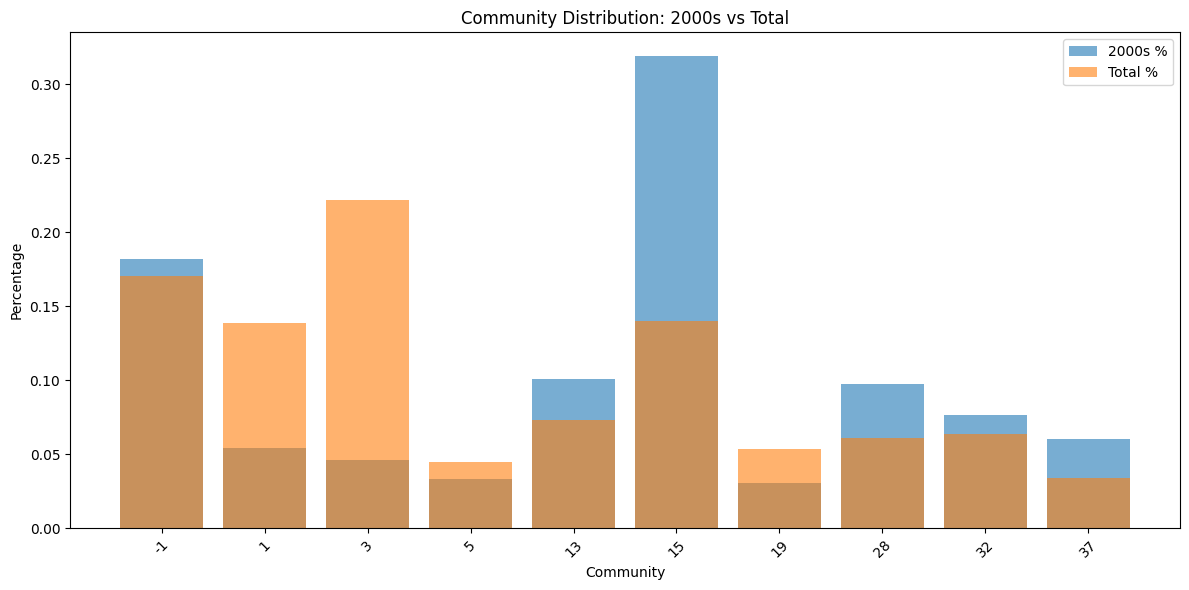

In [8]:
# Perform horizontal analysis using centrality_df_top10 and visualize
# Formula: Community percentage in the 2000s = Number of albums in a community during the 2000s / Total number of albums in the 2000s
# Overall community percentage = Total number of albums in a community / Total number of albums overall

# Calculate the percentage of each community in the 2000s
decade_2000s_total = centrality_df_top10.loc[2000].drop('Total')
total_2000s = decade_2000s_total.sum()

community_2000s_percentage = decade_2000s_total / total_2000s

# Calculate the overall percentage of each community
total_community_distribution = centrality_df_top10.loc['Total'].drop('Total')
overall_total = total_community_distribution.sum()

community_total_percentage = total_community_distribution / overall_total

# Horizontal comparison visualization
plt.figure(figsize=(12, 6))
x_labels = community_2000s_percentage.index.astype(str)
plt.bar(x_labels, community_2000s_percentage, alpha=0.6, label="2000s %")
plt.bar(x_labels, community_total_percentage, alpha=0.6, label="Total %")

plt.title("Community Distribution: 2000s vs Total")
plt.xlabel("Community")
plt.ylabel("Percentage")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


The chart above compares the percentage distribution of albums from the 2000s in each community (yellow bars) with their overall percentage distribution (orange bars).

- **Community 15** accounted for **32%** of albums from the 2000s, while its overall proportion was only **14%**, significantly higher than the proportional changes of other communities. This indicates that Community 16 was the most prominent community in the 2000s.  
- **Community -1**, despite having a large number of albums, consists of isolated nodes and is therefore excluded from the centralization analysis, further highlighting the prominence of Community 15.  
- Other communities such as Community 1 and Community 3 did not show similar significant growth in their proportions during the 2000s, underscoring the unique role of Community 15.

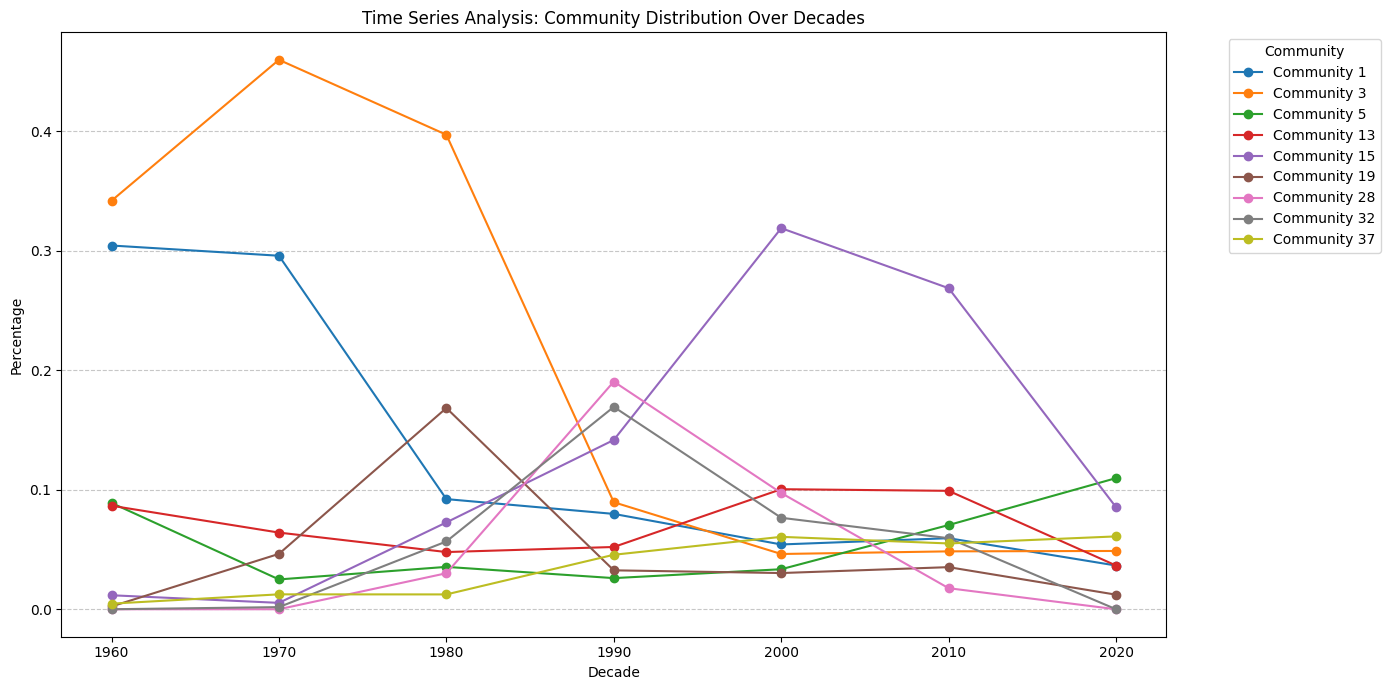

In [9]:
# Time Series Analysis: Analyze the percentage trends of each community over decades

# Remove the column corresponding to Community -1
centrality_df_top10 = centrality_df_top10.drop(columns=-1)

# Calculate the percentage of each community in each decade
percentage_by_decade = centrality_df_top10.div(centrality_df_top10["Total"], axis=0).drop(columns="Total")

# Remove the total row ("Total") and retain actual data
percentage_by_decade = percentage_by_decade.loc[percentage_by_decade.index != 'Total']

# Plot the time series line chart
plt.figure(figsize=(14, 7))

for community in percentage_by_decade.columns:
    plt.plot(
        percentage_by_decade.index,
        percentage_by_decade[community],
        marker='o',
        label=f"Community {community}",
    )

plt.title("Time Series Analysis: Community Distribution Over Decades")
plt.xlabel("Decade")
plt.ylabel("Percentage")
plt.legend(title="Community", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



In the time series chart, Community 15 reached its peak in the 2000s. Observing the period after the 1990s, we find that other communities showed relatively stable changes across decades, without any similar surges.

> **Summary**: Based on the above analysis, it can be concluded that Community 16 not only accounted for **32%** of the total number of albums in the music network during the 2000s but also made up 43% of its own total album count (the second-largest proportion, with the largest being **44%** for Community 32 in the 1990s relative to itself). Additionally, Community 15 exhibited the greatest fluctuations since the 1990s. These findings collectively support the argument that the 2000s served as the central era of the music network, characterized by the strongest connectivity and influence.

#### **Investigation 2: Were albums from the 2010s serve as transitional nodes, linking concentrated older themes with more fragmented newer ones?**


We aim to verify whether the 2010s served as transitional nodes in the music network by connecting multiple communities, continuing older themes while introducing new ones, thus blending the old and the new. To achieve this, we analyze the following two dimensions:

1. **Community Level:** Examine the activity and distribution of multiple communities in the 2010s to explore their role in theme propagation.  

2. **Genre Level:** Compare the distribution and changes of themes across different decades to investigate the characteristics of theme blending in the 2010s.  

##### **Community Level**

At the community level, we calculated the proportion of each community in the 2010s as follows:  
$$
   \text{Proportion of a community in the 2010s} = \frac{\text{Number of albums from a community in the 2010s}}{\text{Total number of albums in the 2010s}}
$$  

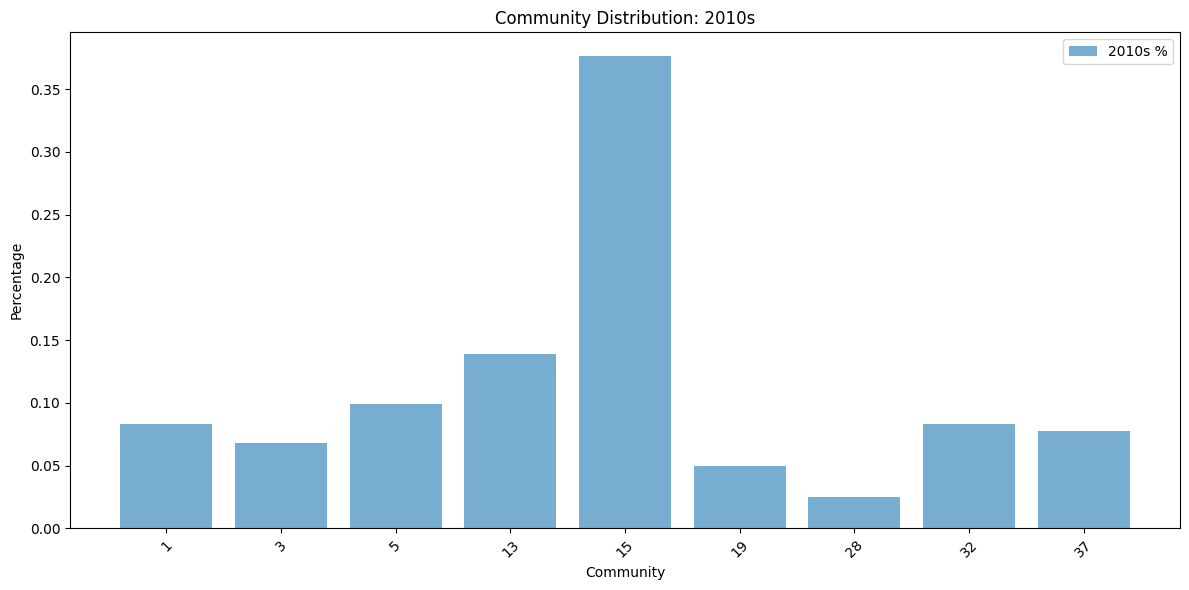

In [10]:
decade_2010s_total = centrality_df_top10.loc[2010].drop('Total')
total_2010s = decade_2010s_total.sum()

community_2010s_percentage = decade_2010s_total / total_2010s

plt.figure(figsize=(12, 6))
x_labels = community_2010s_percentage.index.astype(str)
plt.bar(x_labels, community_2010s_percentage, alpha=0.6, label="2010s %")

plt.title("Community Distribution: 2010s")
plt.xlabel("Community")
plt.ylabel("Percentage")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In the 2010s, we observed that **Community 15** remained the dominant community with the highest proportion, reflecting its continuity during this decade. At the same time, communities such as **13, 15, and 5** also demonstrated relatively high proportions. This indicates that album distribution in the 2010s spanned multiple communities, showcasing genre diversity and integration. Compared to the centralized model of a single dominant community in the 2000s, the 2010s exhibited a more dispersed and balanced distribution, laying the foundation for theme propagation and connection.

> **Summary**: The community-level analysis demonstrates that albums from the 2010s connected multiple communities, forming a transitional node in the network that facilitated genre blending.

##### **Genre Level**

We use word clouds of album themes from the 2000s versus the 2010s to observe whether a transitional period exists.  

/var/folders/rt/lb9jfwsn0d59wvs6_f0ptpjm0000gn/T/ipykernel_51081/3727544809.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  centrality_df_top10_orgian['Genres'] = centrality_df_top10_orgian['Genres'].apply(


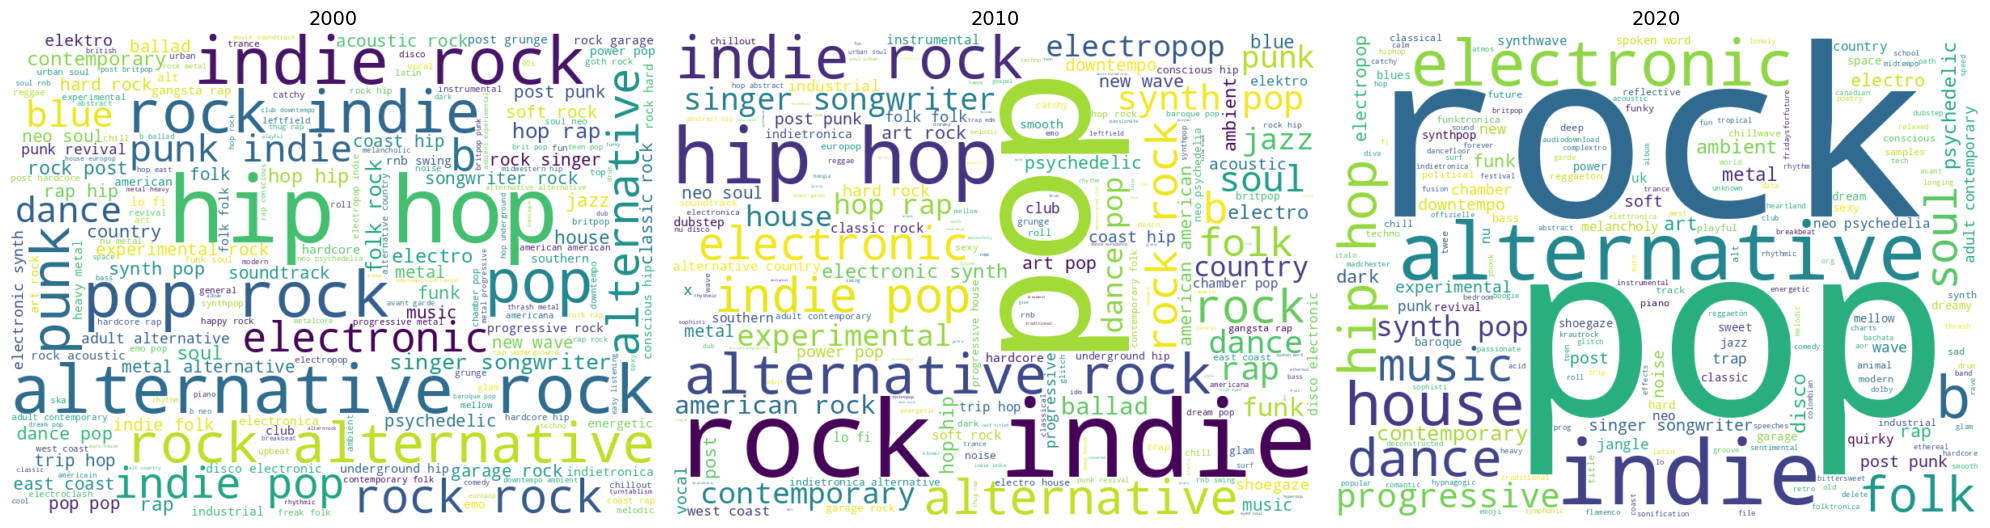

In [12]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import ast

centrality_df_top10_orgian['Genres'] = centrality_df_top10_orgian['Genres'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

fig, axes = plt.subplots(1, 3, figsize=(20, 12))  # 1 row, 3 columns
#fig.suptitle("Word Clouds for Genres from 2000s to 2020s", fontsize=20)

for idx, year in enumerate([2000, 2010, 2020]):
    all_genres = []
    for genres in centrality_df_top10_orgian[centrality_df_top10_orgian['Decade'] == year]['Genres']:
        all_genres.extend(genres)
    
    text = ' '.join(all_genres)
    
    # Create word cloud
    wordcloud = WordCloud(width=800, height=600, background_color='white').generate(text)
    
    ax = axes[idx]  # Access the correct subplot axis
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(year, fontsize=14)  # Set title for each decade
    ax.axis("off")  # Hide axes
plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()

The word cloud comparison shows that the themes of the 2000s were concentrated around **"hip hop," "indie rock,"** and **"alternative rock,"** which dominated the popular music culture of that time. In contrast, the themes of the 2010s became more diverse, with **"pop"** emerging as the dominant theme. At the same time, **"hip hop"** and **"indie rock"** became more prominent compared to the 2000s, while **"alternative rock"** appeared less significant. Additionally, new themes such as **"electropop," "dance pop,"** and **"experimental"** emerged, highlighting the rise of new genres during the 2010s.  

This significant shift reflects how the 2010s balanced the continuation of older themes with the emergence of new ones, marking a transitional period in music.  


#### **Investigation **3:** Do albums post-2010s appear to lose connectivity and centrality, indicating a shift toward more diverse and decentralized music themes?**

To further explore genre changes, we compared word clouds of albums from the 2010s and 2020s.

Compared to the 2010s, the word cloud shows a noticeable decline in the prominence of traditional genres such as **"alternative rock."** At the same time, emerging themes such as **"synth pop," "psychedelic," "house,"** and **"ambient"** have become more prominent, reflecting a high degree of genre diversity.

The boundaries between different themes have become increasingly blurred. For instance, **"electropop"** merges electronic and pop elements, while **"neo soul"** combines soul music with modern influences. This trend signifies a greater degree of genre fusion, with traditional category distinctions starting to dissolve.

---

### **Summary**


Using network centrality metrics, we revealed the connectivity characteristics and overall trends of albums from different years: centralization in the 2000s, a transitional phase in the 2010s, and decentralization after the 2010s. Additionally, we applied community detection methods to analyze the modular structure of the music network, further exploring the accuracy of these observations.  

Our analysis suggests that the 2010s marked a transition in the music industry from unification (dominated by mainstream trends) to decentralization (characterized by niche and individualized styles). This evolution includes the blurring of genre boundaries[1], the fragmentation of traditional genres[2], and the emergence of new micro-genres[3]. This trend may have been driven by external factors such as the rise of streaming platforms[4] and shifts in listener preferences toward the end of the 2010s[5].

------

# **Reference**

[1] Works CitedGoldner, Sam. “The 2010s Were the Decade That Genre Collapsed.” VICE, 5 Nov. 2019, www.vice.com/en/article/2010s-were-the-decade-that-genre-collapsed/. Accessed 4 Dec. 2024.

[2] The Decline of Music Genres. www.560music.com/post/the-decline-of-music-genres.

[3] Works CitedWikipedia Contributors. “Microgenre.” Wikipedia, Wikimedia Foundation, 21 Aug. 2024, en.wikipedia.org/wiki/Microgenre.

[4] Works CitedYellowbrick. “Top 2010s Music Trends: Exploring the Evolution and Influences.” Yellowbrick, 24 Aug. 2023, www.yellowbrick.co/blog/music/top-2010s-music-trends-exploring-the-evolution-and-influences.

[5] Works CitedBello, Pablo, and David Garcia. “Cultural Divergence in Popular Music: The Increasing Diversity of Music Consumption on Spotify across Countries.” Humanities and Social Sciences Communications, vol. 8, no. 1, 27 July 2021, www.nature.com/articles/s41599-021-00855-1, https://doi.org/10.1057/s41599-021-00855-1.

----